# Discharge Notes and Readmission Rates: NLP

This notebook is for the processing the cleaned dataset through a NLP.

## Import

In [1]:
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import string
import re
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.dummy import DummyClassifier

#import xgboost as xg
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, plot_confusion_matrix
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
#from imblearn.over_sampling import SMOTENC
#from imblearn.pipeline import Pipeline as imbpipeline

In [2]:
#set the pandas display column width as max to read in all the text
#pd.set_option('display.max_colwidth', None)

## Functions

In [4]:
def scores(model, X, y, set_type):
    pred = model.predict(X)
    
    print("{} Scores".format(set_type))
    print("accuracy: ", accuracy_score(y, pred))
    print("recall:   ", recall_score(y, pred))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(set_type)
    plot_confusion_matrix(model, X, y, ax=ax)

In [5]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenize(text)]

## Importing the Data

In [6]:
df = pd.read_csv('data/admissions_cleaned.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45591 entries, 0 to 45590
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      45591 non-null  object
 1   ADMISSION_LOCATION  45591 non-null  object
 2   DISCHARGE_LOCATION  45591 non-null  object
 3   INSURANCE           45591 non-null  object
 4   LANGUAGE            45591 non-null  object
 5   RELIGION            45591 non-null  object
 6   MARITAL_STATUS      45591 non-null  object
 7   ETHNICITY           45591 non-null  object
 8   DIAGNOSIS           45591 non-null  object
 9   READMISSION         45591 non-null  int64 
 10  GENDER              45591 non-null  object
 11  AGE                 45591 non-null  int64 
 12  TEXT                45591 non-null  object
 13  CPT_CD              45591 non-null  object
 14  DIAG_ICD9_CODE      45590 non-null  object
 15  DRG_CODE            45591 non-null  object
 16  PROCED_ICD9_CODE    45

## Preprocessing

In [8]:
#set X as the text data, and y as the readmission status
X = df['TEXT']
y = df['READMISSION']

In [9]:
#review the first text example to see how to preprocess the text data
X[0]

"Admission Date:  [**2100-6-7**]              Discharge Date:   [**2100-6-9**]\n\nDate of Birth:  [**2044-4-23**]             Sex:   M\n\nService: MEDICINE\n\nAllergies:\nNo Known Allergies / Adverse Drug Reactions\n\nAttending:[**First Name3 (LF) 2024**]\nChief Complaint:\ndizziness\n\nMajor Surgical or Invasive Procedure:\nNONE\n\n\nHistory of Present Illness:\nHistory of Present Illness: Mr. [**Known lastname 83415**] is a 56 year old male\nwith PMH notable for metastatic cancer (unknown primary)\nundergoing chemo now presenting with lighheadedness and\nhemoptysis. Pt is undergoing chemo with gemcitabine ([**2100-5-24**],\n[**2100-5-31**]) for malignant neoplasm of unknown primary with multiple\nbone, muscle, and soft-tissue metastases. He came to the\nhospital to start RT to L femur today.  Pt reports a couple days\nof lightheadedness, nonpositional.  Pt reports one episode of\nhemoptysis [**2100-6-3**] but none since then. No sig lung lesions on\nchest CT [**2100-5-27**]. Was sche

In [10]:
#remove line breaks and other formatting text
X = X.str.replace('\n',' ')
X = X.str.replace('\r',' ')

#remove punctuations and numbers
punc_list = string.punctuation
num_list = '0123456789'
punc_num_list = punc_list + num_list
pun_num_remove = str.maketrans(dict.fromkeys(punc_num_list, " "))
X = X.str.translate(pun_num_remove)

#lower case the text
X = X.str.lower()

In [11]:
#lemmatize the words
X = X.apply(lemmatize_text)

In [12]:
#join the words together
X = X.apply(' '.join)

## Train, Validation, and Test Split

I split the data set into three sets: Train, Validation, and Test.
The ratio I used was 70:15:15.

In [13]:
X_train, X_v_t, y_train, y_v_t = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [14]:
X_val, X_test, y_val, y_test = train_test_split(X_v_t, y_v_t, test_size=0.50, random_state=42, stratify=y_v_t)

In [15]:
X_train.shape

(31913,)

## Pipeline Parameters

In [16]:
sw = stopwords.words('english')
#max_features = int(X_train.shape[0]*0.10)
max_features = 300

## Modeling

### Model 0: Dummy Classification

In [18]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_features)),
    ('dummy', DummyClassifier(strategy="stratified"))
    ])

Train Scores
accuracy:  0.6129477015636261
recall:    0.2593525179856115
Validation Scores
accuracy:  0.6084222839596433
recall:    0.2511185682326622
Test Scores
accuracy:  0.607106302090949
recall:    0.246782316731953


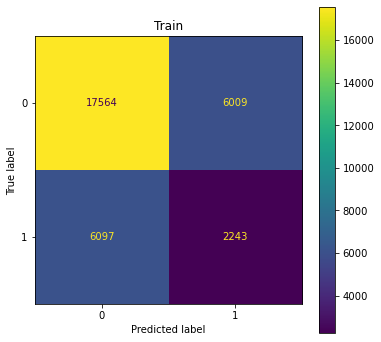

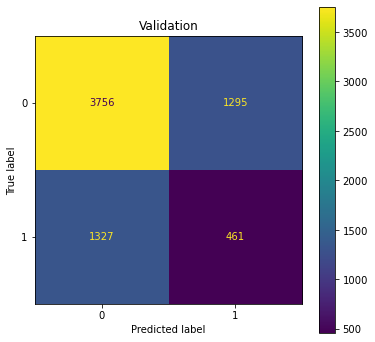

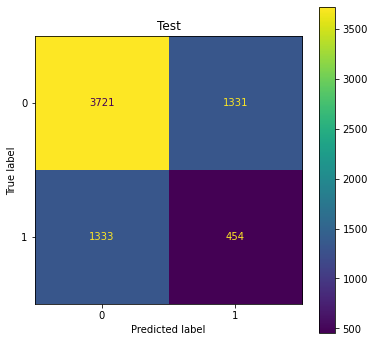

In [19]:
pp_count.fit(X_train, y_train)

scores(pp_count, X_train, y_train, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

In [22]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_features)),
    ('dummy', DummyClassifier(strategy="stratified")),   
    ])

Train Scores
accuracy:  0.6110049196252311
recall:    0.2628297362110312
Validation Scores
accuracy:  0.610469366866501
recall:    0.2639821029082774
Test Scores
accuracy:  0.6110542476970318
recall:    0.25461667599328486


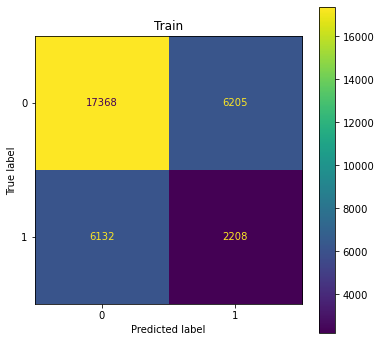

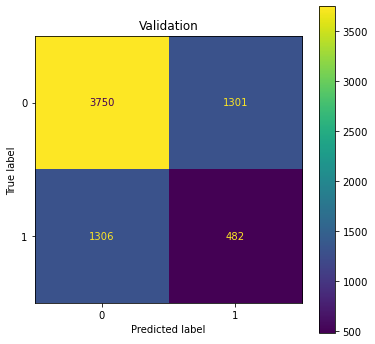

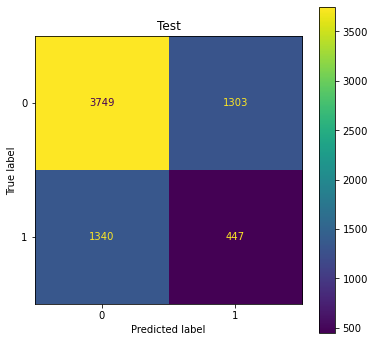

In [23]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

### Model 1: Logistic Regression


In [24]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_features)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7826591044401968
recall:    0.3514388489208633
Validation Scores
accuracy:  0.7756982014914461
recall:    0.34451901565995524
Test Scores
accuracy:  0.7814007895891212
recall:    0.3553441522104085


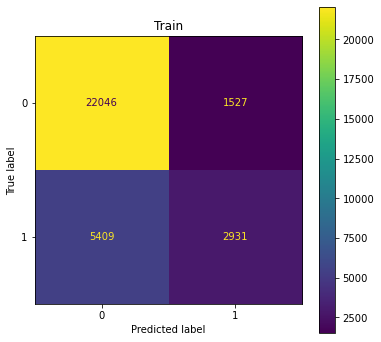

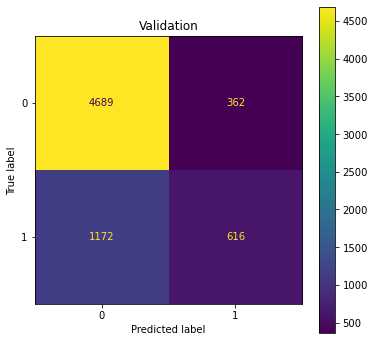

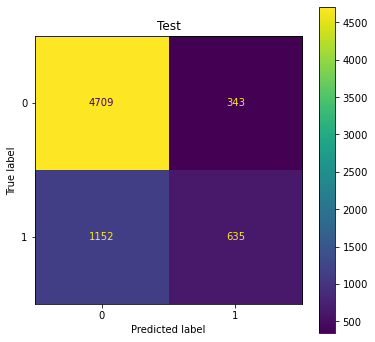

In [25]:
pp_count.fit(X_train, y_train)

scores(pp_count, X_train, y_train, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

In [26]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_features)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7811550151975684
recall:    0.3333333333333333
Validation Scores
accuracy:  0.7730662377540576
recall:    0.31655480984340045
Test Scores
accuracy:  0.7816932300043866
recall:    0.3430330162283156


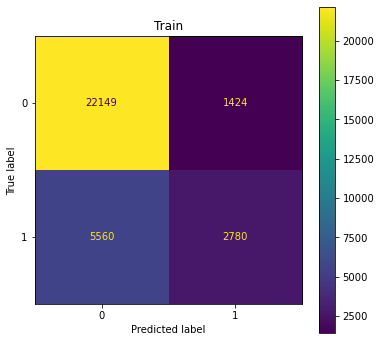

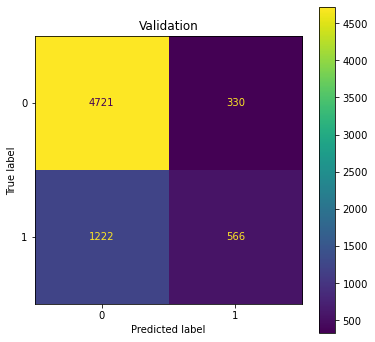

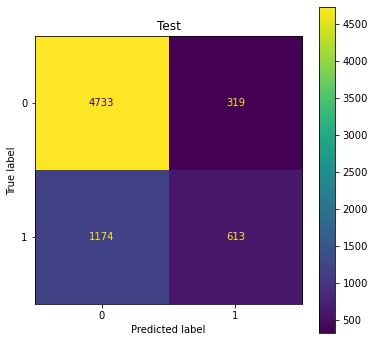

In [27]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

### Model 2: K-Nearest Neighbors

In [29]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_features)),
    ('knn', KNeighborsClassifier()),   
    ])

In [31]:
grid = {'knn__n_neighbors': list(range(1, 20, 2)),
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1, 2, 3, 4]}

In [32]:
gs_knn = GridSearchCV(estimator=pp_count, 
                          param_grid=grid, 
                          scoring='recall', 
                          cv=5)

In [33]:
gs_knn.fit(X_train, y_train)

scores(gs_knn, X_train, y_train, 'Train')
scores(gs_knn, X_val, y_val, 'Validation')
scores(gs_knn, X_test, y_test, 'Test')

KeyboardInterrupt: 

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_features)),
    ('knn', KNeighborsClassifier(random_state=42)),   
    ])

In [ ]:
grid = {'knn__n_neighbors': list(range(1, 20, 2)),
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1, 2, 3, 4]}

In [ ]:
gs_knn = GridSearchCV(estimator=pp_tfidf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=5)

In [ ]:
gs_knn.fit(X_train, y_train)

scores(gs_knn, X_train, y_train, 'Train')
scores(gs_knn, X_val, y_val, 'Validation')
scores(gs_knn, X_test, y_test, 'Test')

### Model 3: Decision Tree Model

### Model 4: Random Forest

### Model 5: XGBoost

### Model 6: AdaBoost

### Model 7: Gradient Boost

### Model 8: Neural Network

### Model 9: Convolutional Neural Network